# Facing the Problem with Feature Processing and Selection

In this notebook is studied the possibility to obtain better results with data pre-processing.
In particular at first the: 
 - Data Standardization;
 - Feature Selection with: 
     - SelectKBest
     - Recursive Feature
     - Random Forest

are tested with the provided dataset. 

After that, the ML algorithms already tested with the original dataset are runned on the new processed data and compared.

In [73]:
# My personal function to plot and print
from my_plotting import plot_roc_and_precision_recall
from my_plotting import plot_confusion_matrix_based_on_prediction
from my_printing import print_results_prediction
from my_plotting import plot_comparison



from platform import python_version
print("Python Version :",python_version())
import pandas as pd
import numpy as np
pd.set_option("precision",3)
from matplotlib import pyplot as plt
import time
import seaborn as sns

#For ML Data Processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

#For ML Classification Algorithms
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#ML Metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve

%matplotlib inline  
seed=4

Python Version : 3.8.10


In [74]:
data=pd.read_csv("sonar.csv",header=None)
X=np.array(data.iloc[:,:-1])
Y=np.array(data[60])
#Convert M->0, R->1
Label_Encoder = preprocessing.LabelEncoder()
Y=Label_Encoder.fit_transform(Y)

----

# Study of possible data processing and Feature Selections

### Data Standardization ( Mean=0, Std=1)

In [75]:
# Standardize data (0 mean, 1 stdev)
scaler = StandardScaler().fit(X)
rescaledX = scaler.transform(X)


----

## Feature Selection
#### (Before selecting feature, better to split into train and test ["Don't look at the test set"])

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=seed)
data_array=np.c_[X_train,Y_train]
rock_features=data_array[data_array[:,-1]==1][:,:-1]
mine_features=data_array[data_array[:,-1]==0][:,:-1]
print("Dataset Shape:" ,X.shape)


Dataset Shape: (208, 60)


## Univariate Selection: Select K-Best

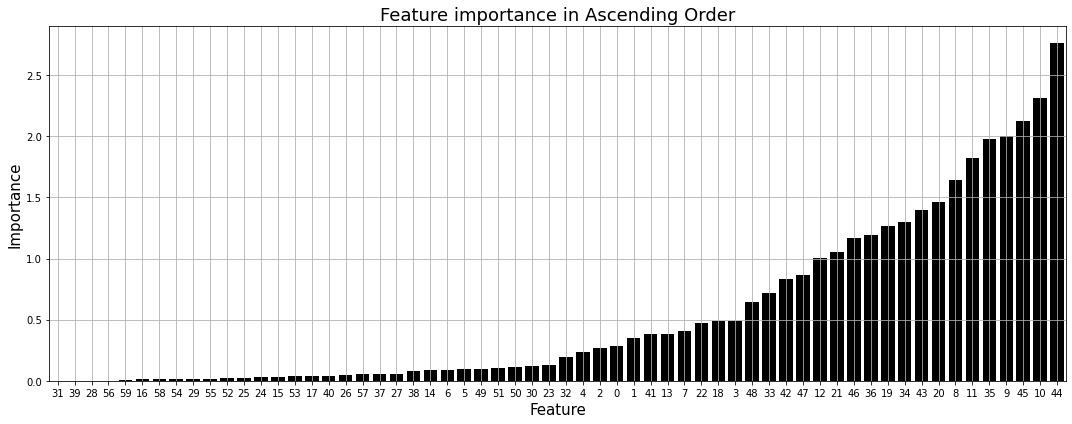

In [77]:
#Test fit
test = SelectKBest(score_func=chi2, k=40)
fit = test.fit(X_train, Y_train)
#Reduction
X_reduced = SelectKBest(score_func=chi2, k=40).fit_transform(X_train, Y_train)
cols = test.get_support(indices=True)
#Plot feature importance:
feature=np.arange(0,60)
importance=fit.scores_
df=pd.DataFrame({"Feature":feature,"Importance":importance})
plt.figure(figsize=(15,6))
sns.barplot(x='Feature',
            y="Importance", 
            data=df, 
            order=df.sort_values('Importance').Feature,color="black")
plt.xlabel("Feature", size=15)
plt.ylabel("Importance", size=15)
plt.title("Feature importance in Ascending Order", size=18)
plt.grid()
plt.tight_layout()

In [78]:
#Creating New Dataframe with reduced features
cols = test.get_support(indices=True)
A=set(np.arange(0,60))
B=set(cols)
DropFeature=list(A-B)
mask=[]
for i in range(0,60):
    if i in DropFeature:
        mask.append(False)
    else:
        mask.append(True)

X_selectKbest=X[:,mask]
print("Dataset Shape after feature selection:" ,X_selectKbest.shape)
data_array=np.c_[X_selectKbest,Y]

Dataset Shape after feature selection: (208, 40)


## Recursive Feature

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=seed)
data_array=np.c_[X_train,Y_train]
rock_features=data_array[data_array[:,-1]==1][:,:-1]
mine_features=data_array[data_array[:,-1]==0][:,:-1]
print("Dataset Shape:" ,X.shape)
model = LogisticRegression(solver='lbfgs', max_iter=500)
rfe = RFE(model,n_features_to_select=40)    # my choice: seek for 3 features
fit = rfe.fit(X_train, Y_train)
#print(X_train)
print("Num Features: %d" % fit.n_features_)
#print("Selected Features: %s" % fit.support_)
#print("Feature Ranking: %s" % fit.ranking_)
mask=fit.support_
X_recursive=X[:,mask]
data_array=np.c_[X_recursive,Y]
print("Dataset Shape after feature selection:" ,X_recursive.shape)


Dataset Shape: (208, 60)
Num Features: 40
Dataset Shape after feature selection: (208, 40)


# Random Forest

Dataset Shape: (208, 60)
Dataset Shape after feature selection: (208, 43)


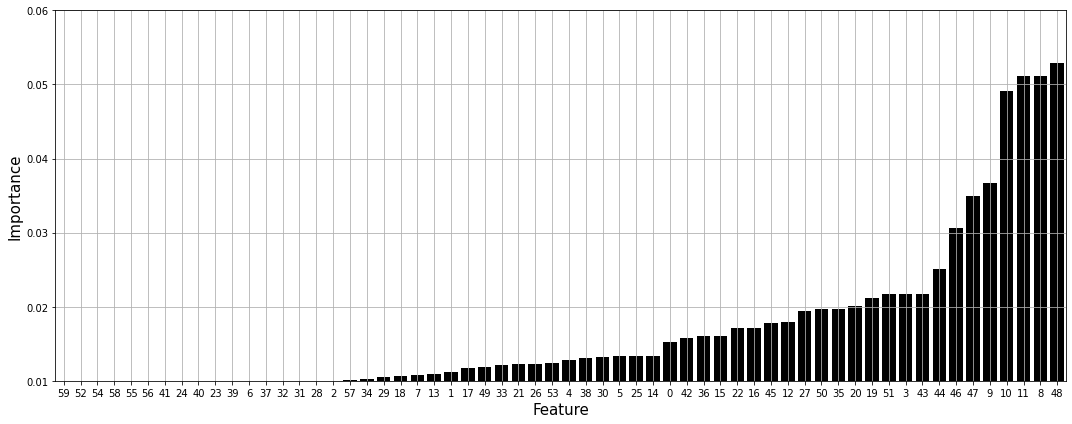

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=seed)
data_array=np.c_[X_train,Y_train]
rock_features=data_array[data_array[:,-1]==1][:,:-1]
mine_features=data_array[data_array[:,-1]==0][:,:-1]
print("Dataset Shape:" ,X.shape)
sel=RandomForestClassifier(n_estimators=1000)
sel.fit(X_train,Y_train)
importance=sel.feature_importances_
mask=importance>=0.01
#Model Definition
feature=np.arange(0,60)
importance=sel.feature_importances_
df=pd.DataFrame({"Feature":feature,"Importance":importance})
plt.figure(figsize=(15,6))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Importance", 
            data=df, 
            order=df.sort_values('Importance').Feature,color="black")
# set labels
plt.xlabel("Feature", size=15)
plt.ylabel("Importance", size=15)
plt.grid()
#plt.title("Sort Bars in Barplot in Ascending Order", size=18)
plt.ylim(0.01,0.06)
plt.tight_layout()
X_tree=X[:,mask]
data_array=np.c_[X_tree,Y]
print("Dataset Shape after feature selection:" ,X_tree.shape)

-----

# Now it's time to adress the classification problem

In [81]:
def preprocessing_and_classification(X_train,Y_train,X_test,Y_test,
                                     pipeline=Pipeline(steps=[('scaler', StandardScaler()), ('LogisticRegression', LogisticRegression())],verbose=True)
                                     ,plot_matrix=False,modelclass="Logistic Regression",processing="Standardization",print_res=False):
    start=time.time()
    pipeline.fit(X_train, Y_train)
    training_time=time.time()-start
    result = pipeline.score(X_test, Y_test)
    Y_predicted = pipeline.predict(X_test)
    accuracy = accuracy_score(y_true=Y_test, y_pred=Y_predicted)
    classification_rep = classification_report(y_true=Y_test,target_names=["Mine","Rock"],y_pred=Y_predicted,output_dict=True)
    if print_res==True:
        print_results_prediction(accuracy,classification_rep,model=modelclass)
    if plot_matrix==True:
        plot_confusion_matrix_based_on_prediction(Y_test,Y_predicted)
    scores = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, scores, pos_label=1)
    #Calculate AUC
    auc = roc_auc_score(Y_test, scores)
    precision, recall, thresholds= precision_recall_curve(Y_test, scores)
    return Y_predicted,accuracy,classification_rep,auc,precision,recall,training_time,scores


#Results:
model=["Logistic Regression","SVM","Decision Tree"]
Y_predicted=[]
accuracy_res=[] #Accuracy Results
training_time=[] #Time need to train
#TPR=[] #True Positive Rate
#FPR=[] #False Positive Rate
#TNR=[] #True Negative Rate
#FNR=[] #False Negative Rate
precision_res=[] #Precision 
recall_res=[] #Recall results
AUC=[] #Area Under the Curve (ROC)
scores_res=[]


def append_results(results,Y_predicted=Y_predicted,accuracy_res=accuracy_res,training_time=training_time,precision_res=precision_res,recall_res=recall_res,AUC=AUC,scores_res=scores_res):
    Y_predicted.append(results[0])
    accuracy_res.append(results[1])
    training_time.append(results[-2])
    precision_res.append(results[2]["Rock"]["precision"])
    recall_res.append(results[2]["Rock"]["recall"])
    AUC.append(results[3])
    scores_res.append(results[-1])
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=seed)
data_array=np.c_[X_train,Y_train]
rock_features=data_array[data_array[:,-1]==1][:,:-1]
mine_features=data_array[data_array[:,-1]==0][:,:-1]
print("Dataset Shape:" ,X.shape)

Dataset Shape: (208, 60)


In [82]:
#Logistic Regression with Original Dataset
print("Logistic Regression with Original Dataset")
pipe = Pipeline([('LogisticRegression', LogisticRegression())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False)
append_results(results)


#Logistic Regression with Standardized Data: 
print("Logistic Regression with Standardized Dataset")
pipe = Pipeline([('scaler', StandardScaler()), ('LogisticRegression', LogisticRegression())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False)

append_results(results)


#Logistic Regression with SelectKBest as features selection:
print("Logistic Regression after features selection (SelectKBest)")
pipe = Pipeline([('scaler', SelectKBest(score_func=chi2, k=40)), ('LogisticRegression', LogisticRegression())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False)

append_results(results)

#Logistic Regression with Recursive features selection: 
print("Logistic Regression after features selection (RecursiveFeature)")
pipe = Pipeline([('scaler', RFE(LogisticRegression(solver='lbfgs', max_iter=5000),n_features_to_select=40)
), ('LogisticRegression', LogisticRegression())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False)

append_results(results)

#Logistic Regression with RandomForest as features selection: 
print("Logistic Regression after features selection (RandomForest)")
pipe = Pipeline([('scaler', SelectFromModel(RandomForestClassifier(n_estimators=1000,random_state=seed),threshold=0.01)), ('LogisticRegression', LogisticRegression())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False)

append_results(results)



Logistic Regression with Original Dataset
[Pipeline]  (step 1 of 1) Processing LogisticRegression, total=   0.0s
Logistic Regression with Standardized Dataset
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing LogisticRegression, total=   0.0s
Logistic Regression after features selection (SelectKBest)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing LogisticRegression, total=   0.0s
Logistic Regression after features selection (RecursiveFeature)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline]  (step 2 of 2) Processing LogisticRegression, total=   0.0s
Logistic Regression after features selection (RandomForest)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.5s
[Pipeline]  (step 2 of 2) Processing LogisticRegression, total=   0.0s


In [83]:
#SVC with Original Dataset
print("SVC with Original Dataset")
pipe = Pipeline([('SVC', svm.SVC(probability=True))],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#Logistic Regression with Standardized Data: 
print("SVC with Standardized Dataset")
pipe = Pipeline([('scaler', StandardScaler()),('SVC', svm.SVC(probability=True))],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#Logistic Regression with SelectKBest as features selection:
print("SVC after features selection (SelectKBest)")
pipe = Pipeline([('scaler', SelectKBest(score_func=chi2, k=40)), ('SVC', svm.SVC(probability=True))],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#Logistic Regression with Recursive features selection: 
print("SVC after features selection (RecursiveFeature)")
pipe = Pipeline([('scaler', RFE(LogisticRegression(solver='lbfgs', max_iter=5000),n_features_to_select=40)
),('SVC', svm.SVC(probability=True))],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#Logistic Regression with RandomForest as features selection: 
print("SVC after features selection (RandomForest)")
pipe = Pipeline([('scaler', SelectFromModel(RandomForestClassifier(n_estimators=1000,random_state=seed),threshold=0.01)), 
                 ('SVC', svm.SVC(probability=True))],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)

SVC with Original Dataset
[Pipeline] ............... (step 1 of 1) Processing SVC, total=   0.0s
SVC with Standardized Dataset
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVC, total=   0.0s
SVC after features selection (SelectKBest)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVC, total=   0.0s
SVC after features selection (RecursiveFeature)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing SVC, total=   0.0s
SVC after features selection (RandomForest)
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   1.6s
[Pipeline] ............... (step 2 of 2) Processing SVC, total=   0.0s


In [84]:
#SVC with Original Dataset
print("Decision Tree with Original Dataset")
pipe = Pipeline([('Decision Tree', tree.DecisionTreeClassifier())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#SVC Regression with Standardized Data: 
print("Decision Tree with Standardized Dataset")
pipe = Pipeline([('scaler', StandardScaler()),('Decision Tree', tree.DecisionTreeClassifier())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#SVC Regression with SelectKBest as features selection:
print("Decision Tree after features selection (SelectKBest)")
pipe = Pipeline([('SelectKBest', SelectKBest(score_func=chi2, k=40)), ('Decision Tree', tree.DecisionTreeClassifier())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#SVC Regression with Recursive features selection: 
print("Decision Tree after features selection (RecursiveFeature)")
pipe = Pipeline([('RecursiveFeature', RFE(LogisticRegression(solver='lbfgs', max_iter=5000),n_features_to_select=40)
),('Decision Tree', tree.DecisionTreeClassifier())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)
#SVC Regression with RandomForest as features selection: 
print("Decision Tree after features selection (RandomForest)")
pipe = Pipeline([('RandomForest', SelectFromModel(RandomForestClassifier(n_estimators=1000,random_state=seed),threshold=0.01)), 
                 ('Decision Tree', tree.DecisionTreeClassifier())],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=False,print_res=False,modelclass="SVC")
append_results(results)

Decision Tree with Original Dataset
[Pipeline] ..... (step 1 of 1) Processing Decision Tree, total=   0.0s
Decision Tree with Standardized Dataset
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Decision Tree, total=   0.0s
Decision Tree after features selection (SelectKBest)
[Pipeline] ....... (step 1 of 2) Processing SelectKBest, total=   0.0s
[Pipeline] ..... (step 2 of 2) Processing Decision Tree, total=   0.0s
Decision Tree after features selection (RecursiveFeature)
[Pipeline] .. (step 1 of 2) Processing RecursiveFeature, total=   0.2s
[Pipeline] ..... (step 2 of 2) Processing Decision Tree, total=   0.0s
Decision Tree after features selection (RandomForest)
[Pipeline] ...... (step 1 of 2) Processing RandomForest, total=   1.5s
[Pipeline] ..... (step 2 of 2) Processing Decision Tree, total=   0.0s


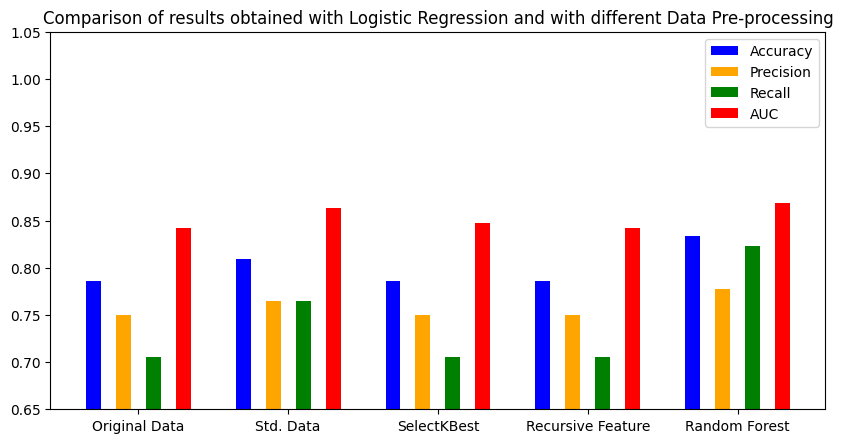

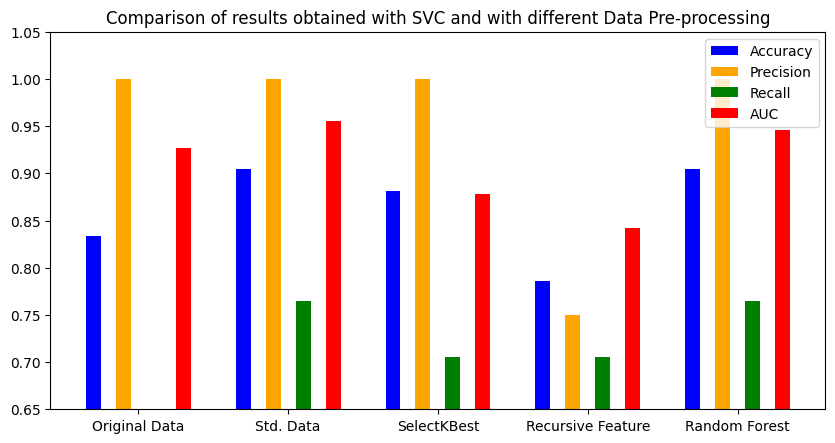

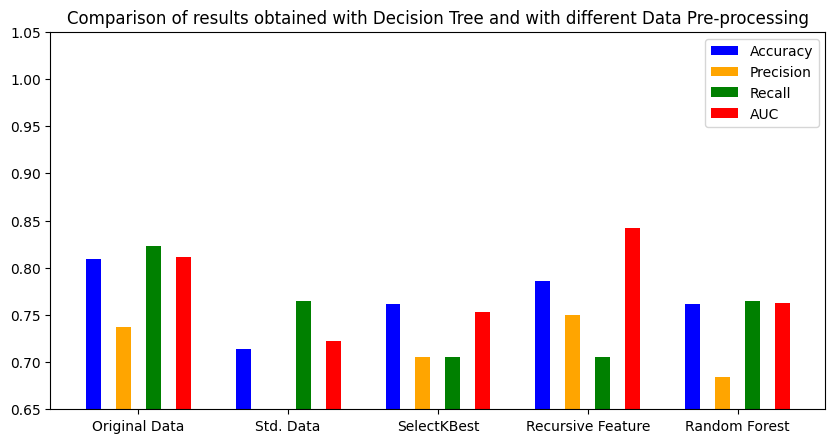

In [85]:
plot_comparison(accuracy_res,precision_res,recall_res,AUC,model=0)
plot_comparison(accuracy_res,precision_res,recall_res,AUC,model=1)
plot_comparison(accuracy_res,precision_res,recall_res,AUC,model=2)

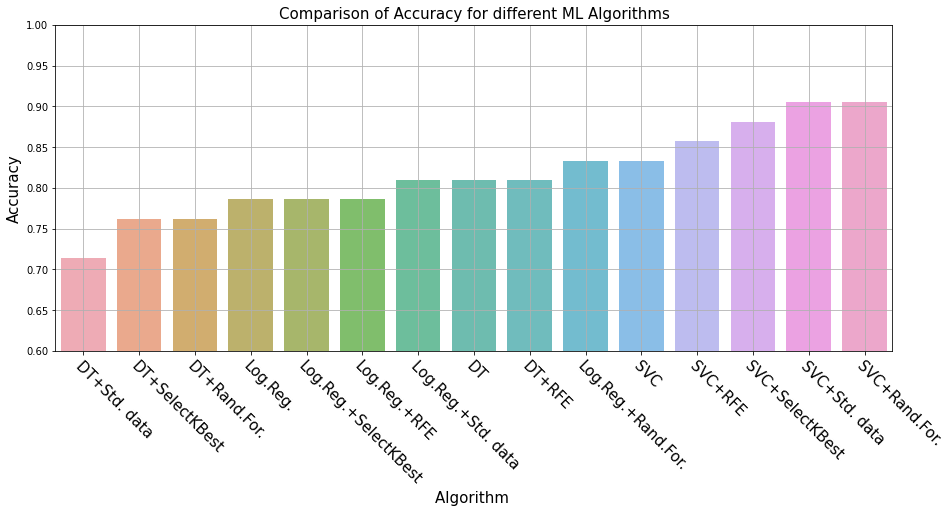

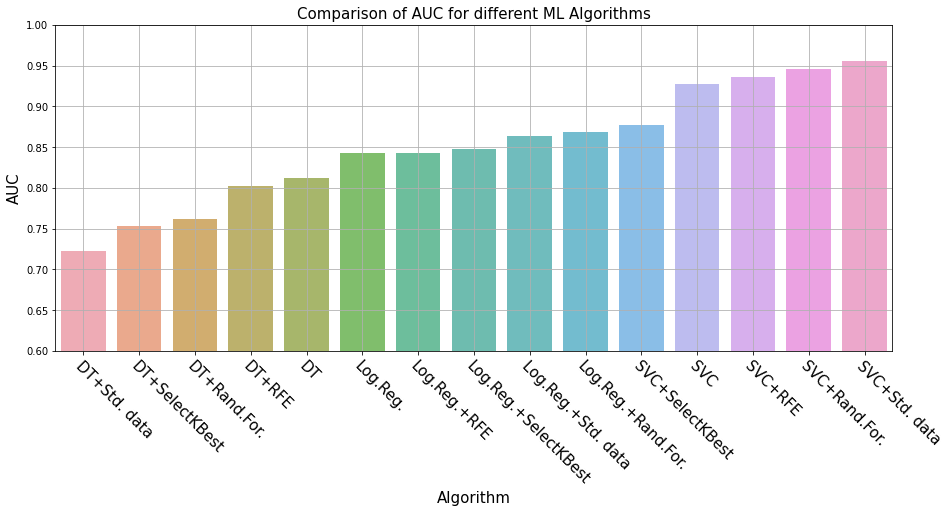

In [86]:
desc=["Log.Reg.","Log.Reg.+Std. data","Log.Reg.+SelectKBest","Log.Reg.+RFE","Log.Reg.+Rand.For.",
     "SVC","SVC+Std. data","SVC+SelectKBest","SVC+RFE","SVC+Rand.For.",
     "DT","DT+Std. data","DT+SelectKBest","DT+RFE","DT+Rand.For.",]
algo=np.arange(0,15)
df=pd.DataFrame({"Algorithm":algo,"Accuracy":accuracy_res,"AlgorithmDescription":desc,"AreaUnderCurve":AUC})
plt.figure(figsize=(15,6))
# make barplot and sort bars


sns.barplot(x='AlgorithmDescription',
            y="Accuracy", 
            data=df, 
            order=df.sort_values('Accuracy').AlgorithmDescription,alpha=0.8)
# set labels
ax=plt.gca()
plt.grid()
plt.xlabel("Algorithm ", size=15)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor",size=15) 
plt.ylabel("Accuracy", size=15)
plt.title("Comparison of Accuracy for different ML Algorithms",size=15)
plt.ylim(0.6,1)
plt.show()

plt.figure(figsize=(15,6))
# make barplot and sort bars


sns.barplot(x='AlgorithmDescription',
            y="AreaUnderCurve", 
            data=df, 
            order=df.sort_values('AreaUnderCurve').AlgorithmDescription,alpha=0.8)
# set labels
ax=plt.gca()
plt.grid()
plt.xlabel("Algorithm", size=15)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor",size=15) 
plt.ylabel("AUC", size=15)
plt.title("Comparison of AUC for different ML Algorithms",size=15)
plt.ylim(0.6,1)
plt.show()

SVC with Standardized Dataset -> Verbose Output
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing SVC, total=   0.0s
Results of SVC:


Accuracy on Test Data = 90.476%


Class "1" (Rock) : 
     precision: 1.000
     recall: 0.765
     f1-score: 0.867


Class "0" (Mine) : 
     precision: 0.862
     recall: 1.000
     f1-score: 0.926




<Figure size 360x360 with 0 Axes>

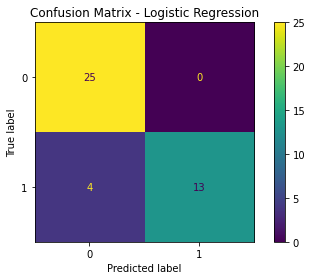

In [87]:
print("SVC with Standardized Dataset -> Verbose Output")
pipe = Pipeline([('scaler', StandardScaler()),('SVC', svm.SVC(probability=True))],verbose=True)
results=preprocessing_and_classification(X_train,Y_train,X_test,Y_test,pipeline=pipe,plot_matrix=True,print_res=True,modelclass="SVC")

Text(0, 0.5, 'True Positive Rate')

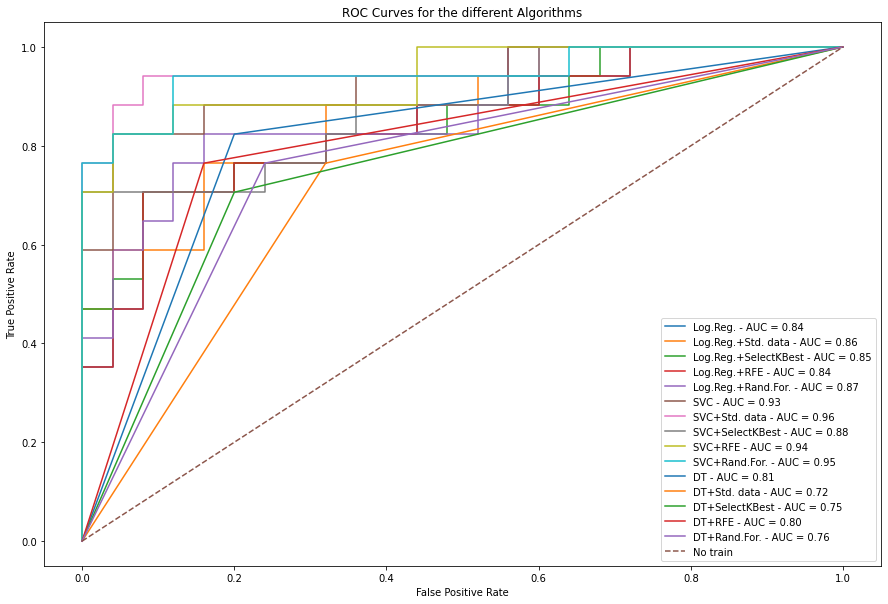

In [88]:
FPR=[]
TPR=[]
fig = plt.figure(figsize=(15, 10))
for i in range(len(scores_res)):
    fpr, tpr, thresholds = roc_curve(Y_test, scores_res[i], pos_label=1)
    plt.plot(fpr, tpr, ls="solid", label="{0} - AUC = {1:.2f}".format(desc[i],AUC[i]),lw=1.5)
plt.plot([0, 1], ls="--",label="No train")
#plt.grid()
plt.legend()
ax=plt.gca()
ax.set_title("ROC Curves for the different Algorithms")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

In [92]:
results_dataframe=pd.DataFrame({"Accuracy":accuracy_res,"Precision":precision_res,"Recall":recall_res,"Training_time":training_time,"AUC":AUC},index=desc)
results_dataframe.to_csv("results.csv")

# Conclusion
Among the Algorithm Tested, for sure the linear Support Vector Classifier with a Feature Reduction or with a Data Standardization, give the best results in terms of Accuracy and AUC. 

In [98]:
pd.read_csv("results.csv",index_col=0)

,Accuracy,Precision,Recall,Training_time,AUC
Log.Reg.,0.786,0.750,0.706,0.032,0.842
Log.Reg.+Std. data,0.810,0.765,0.765,0.012,0.864
Log.Reg.+SelectKBest,0.786,0.750,0.706,0.007,0.847
Log.Reg.+RFE,0.786,0.750,0.706,0.157,0.842
Log.Reg.+Rand.For.,0.833,0.778,0.824,1.458,0.868
SVC,0.833,1.000,0.588,0.019,0.927
SVC+Std. data,0.905,1.000,0.765,0.012,0.955
SVC+SelectKBest,0.881,1.000,0.706,0.012,0.878
SVC+RFE,0.857,1.000,0.647,0.216,0.936
SVC+Rand.For.,0.905,1.000,0.765,1.571,0.946
